In [87]:
import numpy as np
import matplotlib.pyplot as plt
from utilss import *
import copy
import math
from public_tests import *

%matplotlib inline

<a name="2"></a>
## 2 - Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.

<a name="2.1"></a>
### 2.1 Problem Statement

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. 
* You have historical data from previous applicants that you can use as a training set for logistic regression. 
* For each training example, you have the applicant’s scores on two exams and the admissions decision. 
* Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams. 

<a name="2.2"></a>
### 2.2 Loading and visualizing the data

You will start by loading the dataset for this task. 
- The `load_dataset()` function shown below loads the data into variables `X_train` and `y_train`
  - `X_train` contains exam scores on two exams for a student
  - `y_train` is the admission decision 
      - `y_train = 1` if the student was admitted 
      - `y_train = 0` if the student was not admitted 
  - Both `X_train` and `y_train` are numpy arrays.


In [88]:
# load dataset
X_train, y_train = load_data("ex2data1.txt")

In [89]:
print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:",type(X_train))

First five elements in X_train are:
 [[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
Type of X_train: <class 'numpy.ndarray'>


Now print the first five values of `y_train`

In [90]:
print("First ten elements in y_train are:\n", y_train[:10])
print("Type of y_train:",type(y_train))

First ten elements in y_train are:
 [0. 0. 0. 1. 1. 0. 1. 1. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


In [91]:
# check the shape
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (100, 2)
The shape of y_train is: (100,)
We have m = 100 training examples


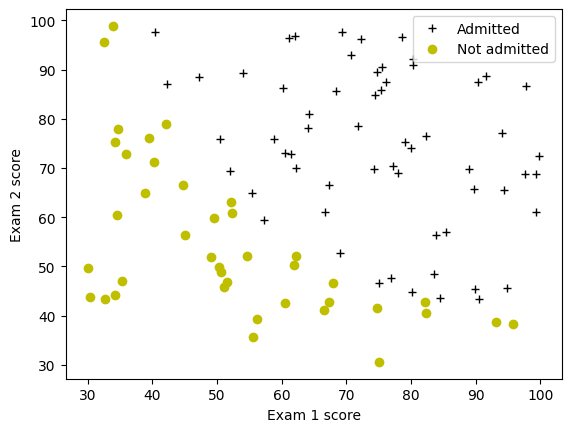

In [92]:
# Plot examples
plot_data(X_train, y_train[:], pos_label="Admitted", neg_label="Not admitted")

# Set the y-axis label
plt.ylabel('Exam 2 score') 
# Set the x-axis label
plt.xlabel('Exam 1 score') 
plt.legend(loc="upper right")
plt.show()

goal is to build a logistic regression model to fit this data.
- With this model, you can then predict if a new student will be admitted based on their scores on the two exams.

In [93]:
#sigmoid fucntion
def sigmoid(z):
    g = 1 / (1+ np.exp(-z))
    return g

In [94]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid([ -1, 0, 1, 2]) = " + str(sigmoid(np.array([-1, 0, 1, 2]))))

sigmoid_test(sigmoid)

sigmoid(0) = 0.5
sigmoid([ -1, 0, 1, 2]) = [0.26894142 0.5        0.73105858 0.88079708]
All tests passed!


In [95]:
# compute cost
def compute_cost(X, y, w, b, lambda_= 1):
    m, n = X.shape
    total_cost = 0
    
    for i in range(m):
        z = np.dot(w, X[i]) + b
        g = sigmoid(z)
        total_cost += (-y[i]*np.log(g)) - (1-y[i])*np.log(1-g)
        
    total_cost = total_cost / m
    return total_cost

In [96]:
#Compute and display cost with w =0
m, n = X_train.shape
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w (zeros): {:.3f}'.format(cost))


Cost at initial w (zeros): 0.693


In [97]:
# Compute and display cost with non-zero w
test_w = np.array([0.2, 0.2])
test_b = -24.
cost = compute_cost(X_train, y_train, test_w, test_b)

print('Cost at test w,b: {:.3f}'.format(cost))


compute_cost_test(compute_cost)


Cost at test w,b: 0.218
All tests passed!


In [98]:
# compute gradient
def compute_gradient(X, y, w, b, lambda_=None): 
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.
    for i in range(m):
        z_wb = np.dot(w, X[i]) + b
        f_wb = sigmoid(z_wb)
        
        dj_db_i = f_wb -y[i]
        dj_db += dj_db_i
        
        for j in range(n):
            dj_dw_ij = (f_wb -y[i]) * X[i,j]
            dj_dw[j] += dj_dw_ij
            
    dj_dw = dj_dw/m
    dj_db = dj_db/m      
    return dj_db, dj_dw

In [99]:
# Compute and display gradient with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w (zeros):{dj_db}' )
print(f'dj_dw at initial w (zeros):{dj_dw}' )

dj_db at initial w (zeros):-0.1
dj_dw at initial w (zeros):[-12.00921659 -11.26284221]


In [100]:
# Compute and display cost and gradient with non-zero w
test_w = np.array([ 0.2, -0.5])
test_b = -24
dj_db, dj_dw  = compute_gradient(X_train, y_train, test_w, test_b)

print('dj_db at test_w:', dj_db)
print('dj_dw at test_w:', dj_dw.tolist())

 
compute_gradient_test(compute_gradient)


dj_db at test_w: -0.5999999999991071
dj_dw at test_w: [-44.831353617873795, -44.37384124953978]
All tests passed!


In [101]:
# gradient desent
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    m = len(X)
    J_history = []
    w_history = []
    
    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history 

In [102]:
intial_w = 0.01 * (np.random.rand(2).reshape(-1,1) - 0.5)
initial_b = -8

iterations = 100000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     1.01   


Iteration 10000: Cost     0.30   
Iteration 20000: Cost     0.30   
Iteration 30000: Cost     0.30   
Iteration 40000: Cost     0.29   
Iteration 50000: Cost     0.29   
Iteration 60000: Cost     0.29   
Iteration 70000: Cost     0.28   
Iteration 80000: Cost     0.28   
Iteration 90000: Cost     0.28   
Iteration 99999: Cost     0.28   


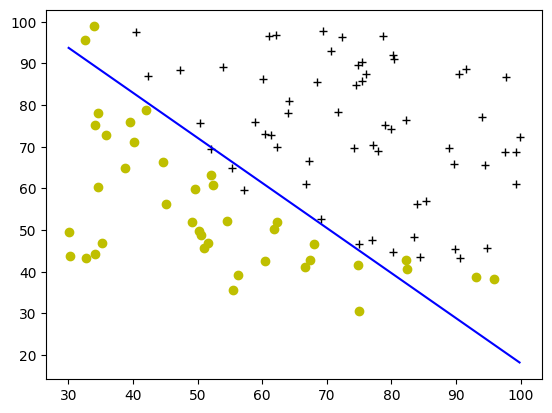

In [103]:
# plot decision boundary 
plot_decision_boundary(w, b, X_train, y_train)

In [104]:
def predict(X, w, b): 
    m, n = X.shape   
    p = np.zeros(m)
    for i in range(m):   
        z_wb = 0
        for j in range(n): 
            z_wb += X[i,j] * w[j]
        
        z_wb += b
        
        f_wb = sigmoid(z_wb)

        p[i] = f_wb >= 0.5
    return p

In [105]:
# Test predict code

np.random.seed(1)
tmp_w = np.random.randn(2)
tmp_b = 0.3    
tmp_X = np.random.randn(4, 2) - 0.5

tmp_p = predict(tmp_X, tmp_w, tmp_b)
print(f'Output of predict: shape {tmp_p.shape}, value {tmp_p}')

   
predict_test(predict)

Output of predict: shape (4,), value [0. 1. 1. 1.]
All tests passed!


Now let's use this to compute the accuracy on the training set

In [106]:
#Compute accuracy on our training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 91.000000


In [107]:
# load dataset
X_train, y_train = load_data("ex2data2.txt")

In [108]:
# print X_train
print("X_train:", X_train[:5])
print("Type of X_train:",type(X_train))

# print y_train
print("y_train:", y_train[:5])
print("Type of y_train:",type(y_train))

X_train: [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
Type of X_train: <class 'numpy.ndarray'>
y_train: [1. 1. 1. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


In [109]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (118, 2)
The shape of y_train is: (118,)
We have m = 118 training examples


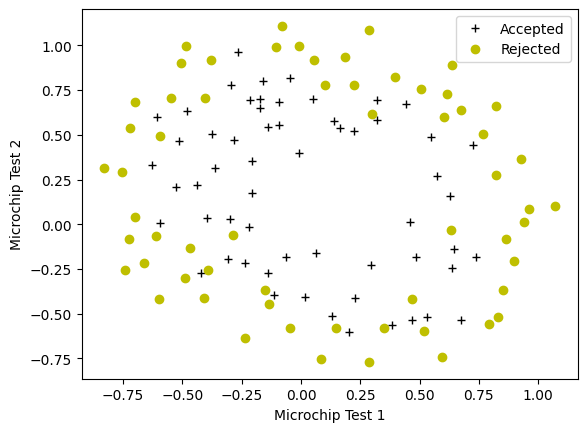

In [110]:
# Plot examples
plot_data(X_train, y_train[:], pos_label="Accepted", neg_label="Rejected")

# Set the y-axis label
plt.ylabel('Microchip Test 2') 
# Set the x-axis label
plt.xlabel('Microchip Test 1') 
plt.legend(loc="upper right")
plt.show()

<a name="3.3"></a>
### 3.3 Feature mapping

One way to fit the data better is to create more features from each data point. In the provided function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$\mathrm{map\_feature}(x) = 
\left[\begin{array}{c}
x_1\\
x_2\\
x_1^2\\
x_1 x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1 x_2^5\\
x_2^6\end{array}\right]$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 27-dimensional vector. 

- A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will be nonlinear when drawn in our 2-dimensional plot. 
- We have provided the `map_feature` function for you in utils.py. 

In [111]:
print("Original shape of data:", X_train.shape)

mapped_X =  map_feature(X_train[:, 0], X_train[:, 1])
print("Shape after feature mapping:", mapped_X.shape)

Original shape of data: (118, 2)
Shape after feature mapping: (118, 27)


Let's also print the first elements of `X_train` and `mapped_X` to see the tranformation.

In [120]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])
mapped_X

X_train[0]: [0.051267 0.69956 ]
mapped X_train[0]: [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]


array([[ 5.12670000e-02,  6.99560000e-01,  2.62830529e-03, ...,
         6.29470940e-04,  8.58939846e-03,  1.17205992e-01],
       [-9.27420000e-02,  6.84940000e-01,  8.60107856e-03, ...,
         1.89305413e-03, -1.39810280e-02,  1.03255971e-01],
       [-2.13710000e-01,  6.92250000e-01,  4.56719641e-02, ...,
         1.04882142e-02, -3.39734512e-02,  1.10046893e-01],
       ...,
       [-4.84450000e-01,  9.99270000e-01,  2.34691802e-01, ...,
         2.34007252e-01, -4.82684337e-01,  9.95627986e-01],
       [-6.33640000e-03,  9.99270000e-01,  4.01499650e-05, ...,
         4.00328554e-05, -6.31330588e-03,  9.95627986e-01],
       [ 6.32650000e-01, -3.06120000e-02,  4.00246023e-01, ...,
         3.51474517e-07, -1.70067777e-08,  8.22905998e-10]])

In [121]:
# compute cost regularization
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    m, n = X.shape
    cost_without_reg = compute_cost(X, y, w, b) 
    reg_cost = 0.
       
    for j in range(n):
        reg_cost_j = w[j]**2
        reg_cost += reg_cost_j
    total_cost = cost_without_reg + (lambda_/(2 * m)) * reg_cost

    return total_cost

Run the cell below to check your implementation of the `compute_cost_reg` function.

In [123]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print("Regularized cost :", cost)


compute_cost_reg_test(compute_cost_reg)


Regularized cost : 0.6618252552483948
All tests passed!


In [115]:
# compute gradient for regularized
def compute_gradient_reg(X, y, w, b, lambda_ = 1): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X : (ndarray Shape (m,n))   variable such as house size 
      y : (ndarray Shape (m,))    actual value 
      w : (ndarray Shape (n,))    values of parameters of the model      
      b : (scalar)                value of parameter of the model  
      lambda_ : (scalar,float)    regularization constant
    Returns
      dj_db: (scalar)             The gradient of the cost w.r.t. the parameter b. 
      dj_dw: (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 

    """
    m, n = X.shape
    
    dj_db, dj_dw = compute_gradient(X, y, w, b)

    ### START CODE HERE ###     
    for j in range(n):
        dj_dw_j_reg = (lambda_/m) * w[j]
        dj_dw[j] += dj_dw_j_reg
        
    ### END CODE HERE ###         
        
    return dj_db, dj_dw

Run the cell below to check your implementation of the `compute_gradient_reg` function.

In [125]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1) 
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5 
initial_b = 0.5
 
lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"First few elements of regularized dj_dw:\n {dj_dw[:4].tolist()}", )


compute_gradient_reg_test(compute_gradient_reg)


dj_db: 0.07138288792343662
First few elements of regularized dj_dw:
 [-0.010386028450548701, 0.011409852883280122, 0.0536273463274574, 0.003140278267313462]
All tests passed!


###  Learning parameters using gradient descent

In [126]:
# Initialize fitting parameters
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ to 1 (you can try varying this)
lambda_ = 0.01;                                          
# Some gradient descent settings
iterations = 10000
alpha = 0.01

w,b, J_history,_ = gradient_descent(X_mapped, y_train, initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

Iteration    0: Cost     0.72   
Iteration 1000: Cost     0.59   
Iteration 2000: Cost     0.56   
Iteration 3000: Cost     0.53   
Iteration 4000: Cost     0.51   
Iteration 5000: Cost     0.50   
Iteration 6000: Cost     0.48   
Iteration 7000: Cost     0.47   
Iteration 8000: Cost     0.46   
Iteration 9000: Cost     0.45   
Iteration 9999: Cost     0.45   


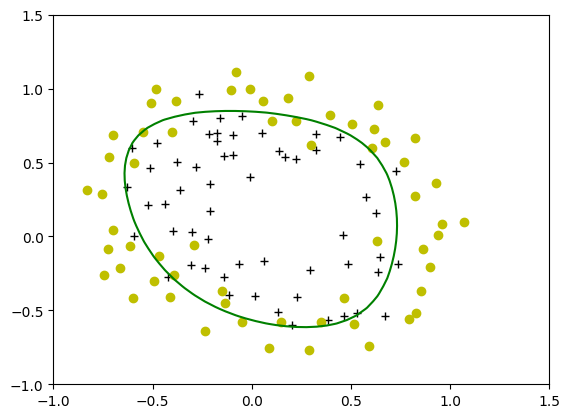

In [127]:
# plot boundary
plot_decision_boundary(w, b, X_mapped, y_train)

In [129]:
#Compute accuracy on the training set
p = predict(X_mapped, w, b)

print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 82.203390
